In [26]:
!pip install torch torchvision opencv-python pillow matplotlib umap-learn pandas seaborn



  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [9]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\admin\appdata\local\temp\pip-req-build-v88qyl1c
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\ADMIN\AppData\Local\Temp\pip-req-build-v88qyl1c'


In [11]:
import torch
import os
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from umap import UMAP
from segment_anything import sam_model_registry
import time
import pandas as pd

# ✅ Use CUDA if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


In [22]:

# ✅ Load SAM model to device
checkpoint_path = "sam_vit_b.pth"

sam = sam_model_registry["vit_b"](checkpoint=checkpoint_path).to(device)
sam.eval()

# ✅ Image preprocessing transform
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ HSV filtering for red masks
def hsv_filter(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower_red1, upper_red1) + cv2.inRange(hsv, lower_red2, upper_red2)
    return cv2.bitwise_and(img, img, mask=mask)

# ✅ Convert image to tensor
def load_image_tensor(path):
    img = cv2.imread(path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_filtered = hsv_filter(img_rgb)
    pil_img = Image.fromarray(img_filtered)
    tensor = transform(pil_img).unsqueeze(0)
    return tensor.to(device)

# ✅ Batch-wise feature extraction
def extract_features(image_paths, batch_size=4):
    features = []
    image_names = []
    total = len(image_paths)

    for i in range(0, total, batch_size):
        batch = image_paths[i:i+batch_size]
        img_tensors = []
        valid_names = []

        for path in batch:
            tensor = load_image_tensor(path)
            if tensor is not None:
                img_tensors.append(tensor)
                valid_names.append(os.path.basename(path))

        if not img_tensors:
            continue

        img_tensors = torch.cat(img_tensors).to(device)

        with torch.no_grad():
            outputs = sam.image_encoder(img_tensors)  # shape: [B, 256, 64, 64]
            for out in outputs:
                feat = out.mean(dim=(1, 2)).cpu().numpy()
                features.append(feat)

        image_names.extend(valid_names)
        print(f"[{i+len(batch)}/{total}] images processed")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return features, image_names

# ✅ Dataset folder
image_folder = r'C:\yolo realcolon work\feature_extraction\dataset_for_feature_extraction\train_polyp\polyp'
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
               if f.lower().endswith((".jpg", ".jpeg", ".png"))]


c:\Users\ADMIN\anaconda3\envs\torch_cuda\lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [23]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()


In [24]:

# ✅ Estimate time using a sample batch
sample_batch = image_paths[:16]
start = time.time()
_ = extract_features(sample_batch, batch_size=4)
duration = time.time() - start
estimated_time = (duration / len(sample_batch)) * len(image_paths) / 60
print(f"🕒 Estimated total time for {len(image_paths)} images: {estimated_time:.2f} minutes")

# ✅ Full feature extraction
all_features, all_image_names = extract_features(image_paths, batch_size=4)

# ✅ Save features to CSV
if all_features:
    df = pd.DataFrame(all_features)
    df.insert(0, "image_name", all_image_names)
    df.to_csv("sam_features.csv", index=False)
    print("✅ Features saved to 'sam_features.csv'")
else:
    print("❌ No features extracted.")


[4/16] images processed
[8/16] images processed
[12/16] images processed
[16/16] images processed
🕒 Estimated total time for 31892 images: 232.20 minutes
[4/31892] images processed
[8/31892] images processed
[12/31892] images processed
[16/31892] images processed
[20/31892] images processed
[24/31892] images processed
[28/31892] images processed
[32/31892] images processed
[36/31892] images processed
[40/31892] images processed
[44/31892] images processed
[48/31892] images processed
[52/31892] images processed
[56/31892] images processed
[60/31892] images processed
[64/31892] images processed
[68/31892] images processed
[72/31892] images processed
[76/31892] images processed
[80/31892] images processed
[84/31892] images processed
[88/31892] images processed
[92/31892] images processed
[96/31892] images processed
[100/31892] images processed
[104/31892] images processed
[108/31892] images processed
[112/31892] images processed
[116/31892] images processed
[120/31892] images processed
[1

In [27]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


# original workflow

In [29]:

import pandas as pd

# Step 1: Load correctly with header
df = pd.read_csv("C:\other experiment\sam\sam_features.csv")  # Header assumed if filenames present

# ✅ Remove non-numeric columns like 'filename'
numeric_df = df.select_dtypes(include=[np.number])  # Automatically removes filename
mobilenet_features = numeric_df.values  # clean numeric array for UMAP

from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
mobilenet_reduced = selector.fit_transform(mobilenet_features)


def evaluate(name, features, labels):
    print(f"\n📊 {name} Evaluation:")
    if len(set(labels)) > 1 and -1 not in set(labels):
        print(f"Silhouette Score: {silhouette_score(features, labels):.4f}")
        print(f"Davies-Bouldin Index: {davies_bouldin_score(features, labels):.4f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz_score(features, labels):.4f}")
    else:
        print("❌ Not enough valid clusters for evaluation.")



import umap

umap_model = umap.UMAP(
    n_neighbors=10,          # try 5, 10, 15, 30
    min_dist=0.05,          # lower → tighter clusters
    # n_components=10,        # use more dimensions for better cluster separation
    metric="euclidean",        # cosine distance works well with image features
    random_state=42
)
umap_features = umap_model.fit_transform(mobilenet_reduced)


# ---------------------------
# Step 3: Normalize
# ---------------------------
scaler = StandardScaler()
scaled_features = scaler.fit_transform(umap_features)

kmeans_labels = KMeans(n_clusters=2, random_state=42).fit_predict(scaled_features)
evaluate("KMeans", scaled_features, kmeans_labels)


# ✅ Agglomerative (Euclidean)
agglo = AgglomerativeClustering(n_clusters=2, metric="euclidean", linkage="ward")  #metric="eucledian"/manhattan
agglo_labels_euclidean = agglo.fit_predict(scaled_features)

evaluate("Agglomerative (euclidean)", scaled_features, agglo_labels_euclidean)



c:\Users\ADMIN\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\torch_cuda\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



📊 KMeans Evaluation:
Silhouette Score: 0.3728
Davies-Bouldin Index: 1.1194
Calinski-Harabasz Index: 21051.8418

📊 Agglomerative (euclidean) Evaluation:
Silhouette Score: 0.3725
Davies-Bouldin Index: 1.1052
Calinski-Harabasz Index: 19201.9766


# scaling=Normalizer and metric= correlation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap

# Load features
df = pd.read_csv("C:/other experiment/sam/sam_features.csv")
mobilenet_features = df.select_dtypes(include=[np.number]).values  # Remove non-numeric columns

# Variance Threshold
selector = VarianceThreshold(threshold=0.01)
mobilenet_reduced = selector.fit_transform(mobilenet_features)

# UMAP for dimensionality reduction
umap_model = umap.UMAP(
    n_neighbors=10,
    min_dist=0.05,
    metric="cosine",
    random_state=42
)
umap_features = umap_model.fit_transform(mobilenet_reduced)

# Apply Normalizer (L2 norm)
scaler = Normalizer(norm='l2')
scaled_features = scaler.fit_transform(umap_features)

# Evaluation Function
def evaluate(name, features, labels):
    print(f"\n📊 {name} Evaluation:")
    if len(set(labels)) > 1 and -1 not in set(labels):
        print(f"Silhouette Score: {silhouette_score(features, labels):.4f}")
        print(f"Davies-Bouldin Index: {davies_bouldin_score(features, labels):.4f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz_score(features, labels):.4f}")
    else:
        print("❌ Not enough valid clusters for evaluation.")

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
evaluate("KMeans (Normalizer (L2))", scaled_features, kmeans_labels)

# Agglomerative Clustering with Correlation Distance
agg_corr = AgglomerativeClustering(n_clusters=2, metric='correlation', linkage='average')
agg_labels_corr = agg_corr.fit_predict(scaled_features)
evaluate("Agglomerative Correlation (Normalizer (L2))", scaled_features, agg_labels_corr)


c:\Users\ADMIN\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\torch_cuda\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



📊 KMeans (Normalizer (L2)) Evaluation:
Silhouette Score: 0.4711
Davies-Bouldin Index: 0.9872
Calinski-Harabasz Index: 26046.1836

📊 Agglomerative Correlation (Normalizer (L2)) Evaluation:
Silhouette Score: 0.4459
Davies-Bouldin Index: 1.0299
Calinski-Harabasz Index: 24538.4766


# UMAP metric= correlation, agglomerative metric=correlation, with Normalizer

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap

# Load features
df = pd.read_csv("C:/other experiment/sam/sam_features.csv")
mobilenet_features = df.select_dtypes(include=[np.number]).values  # Remove non-numeric columns

# Variance Threshold
selector = VarianceThreshold(threshold=0.01)
mobilenet_reduced = selector.fit_transform(mobilenet_features)

# UMAP for dimensionality reduction
umap_model = umap.UMAP(
    n_neighbors=10,
    min_dist=0.05,
    metric="correlation",
    random_state=42
)
umap_features = umap_model.fit_transform(mobilenet_reduced)

# Apply Normalizer (L2 norm)
scaler = Normalizer(norm='l2')
scaled_features = scaler.fit_transform(umap_features)

# Evaluation Function
def evaluate(name, features, labels):
    print(f"\n📊 {name} Evaluation:")
    if len(set(labels)) > 1 and -1 not in set(labels):
        print(f"Silhouette Score: {silhouette_score(features, labels):.4f}")
        print(f"Davies-Bouldin Index: {davies_bouldin_score(features, labels):.4f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz_score(features, labels):.4f}")
    else:
        print("❌ Not enough valid clusters for evaluation.")

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
evaluate("KMeans (Normalizer (L2))", scaled_features, kmeans_labels)

# Agglomerative Clustering with Correlation Distance
agg_corr = AgglomerativeClustering(n_clusters=2, metric='correlation', linkage='average')
agg_labels_corr = agg_corr.fit_predict(scaled_features)
evaluate("Agglomerative Correlation (Normalizer (L2))", scaled_features, agg_labels_corr)



c:\Users\ADMIN\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\torch_cuda\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



📊 KMeans (Normalizer (L2)) Evaluation:
Silhouette Score: 0.4756
Davies-Bouldin Index: 0.9145
Calinski-Harabasz Index: 28793.7383

📊 Agglomerative Correlation (Normalizer (L2)) Evaluation:
Silhouette Score: 0.4555
Davies-Bouldin Index: 0.9275
Calinski-Harabasz Index: 26496.5566


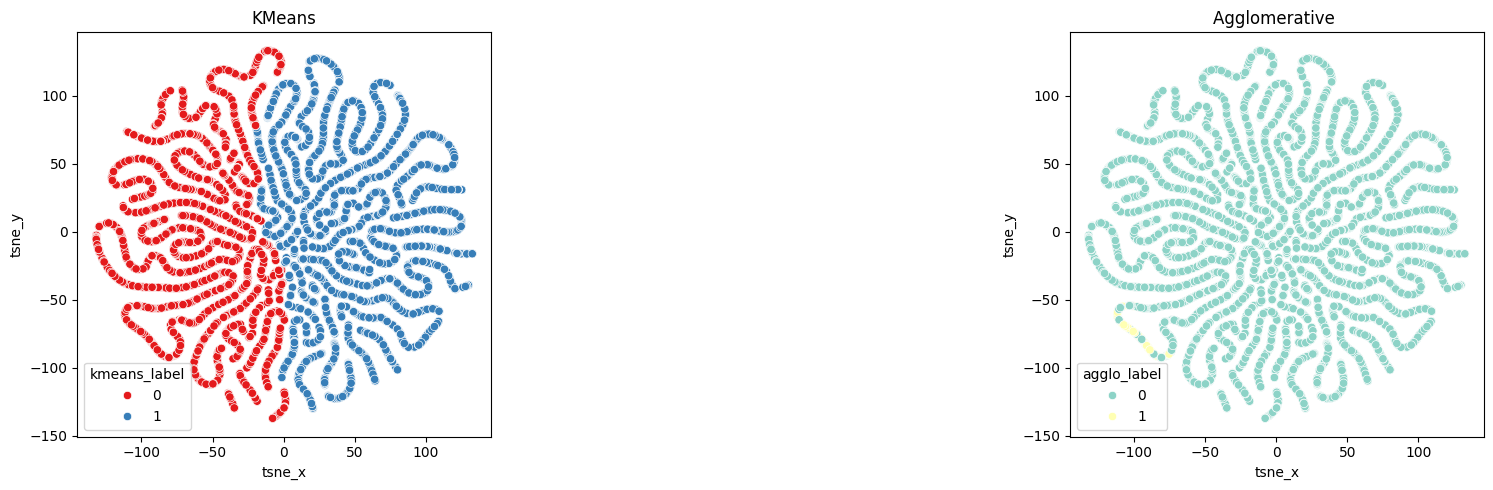

In [44]:
# ---------------------------
# Step 6: Save Results
# ---------------------------
df_result = pd.DataFrame(scaled_features)
df_result["kmeans_label"] = kmeans_labels
df_result["agglo_label"] = agg_labels_corr
df_result.to_csv("sam_features_umap_clustering1.csv", index=False)


# ---------------------------
# Step 7: t-SNE Visualization
# ---------------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_2d = tsne.fit_transform(scaled_features)
df_result["tsne_x"] = tsne_2d[:, 0]
df_result["tsne_y"] = tsne_2d[:, 1]

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="kmeans_label", palette="Set1")
plt.title("KMeans")


plt.subplot(1, 4, 3)
sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="agglo_label", palette="Set3")
plt.title("Agglomerative ")

# plt.subplot(1, 4, 4)
# sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="spectral_label", palette="coolwarm")
# plt.title("Spectral Clustering")

plt.tight_layout()
plt.show()


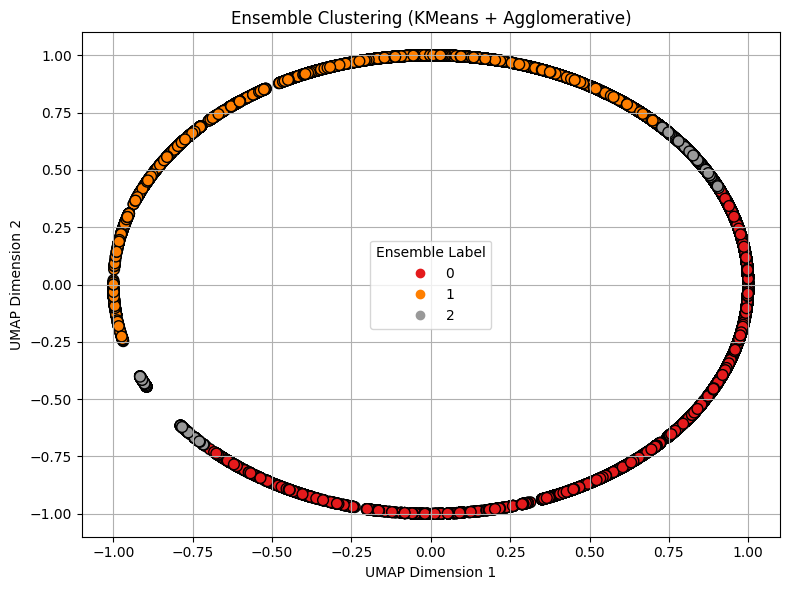

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file with clustering results
df = pd.read_csv("sam_features_umap_clustering1.csv")

# Compute ensemble labels based on agreement between KMeans and Agglomerative
def compute_ensemble(k, a):
    if k == a:
        return k
    else:
        return 2

df["ensemble_label"] = df.apply(lambda row: compute_ensemble(row["kmeans_label"], row["agglo_label"]), axis=1)

# Save new CSV with ensemble labels
df.to_csv("sam_features_umap_clustering1_ensemble.csv", index=False)

# Plotting (assumes first two columns are 2D UMAP features)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df.iloc[:, 0], df.iloc[:, 1],
    c=df["ensemble_label"], cmap='Set1', edgecolor='k', s=60
)
plt.title("Ensemble Clustering (KMeans + Agglomerative)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(*scatter.legend_elements(), title="Ensemble Label")
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Load your CSV with ensemble_label
df = pd.read_csv("sam_features_umap_clustering1_ensemble.csv")

# Use the 2D UMAP features (assumed to be first 2 columns)
X = df.iloc[:, 0:2].values
y = df["ensemble_label"].values

# Filter out points labeled as 2 (disagreement/mismatch) if you only want to evaluate clearly agreed clusters (0 and 1)
# Otherwise, keep as-is to evaluate all 3 clusters

if len(set(y)) > 1 and len(set(y)) <= len(X):  # Ensure at least 2 unique clusters
    sil_score = silhouette_score(X, y)
    dbi = davies_bouldin_score(X, y)
    chi = calinski_harabasz_score(X, y)

    print(f"📊 Ensemble Clustering Evaluation:")
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Index: {dbi:.4f}")
    print(f"Calinski-Harabasz Index: {chi:.4f}")
else:
    print("❌ Not enough valid clusters to evaluate.")


📊 Ensemble Clustering Evaluation:
Silhouette Score: 0.2941
Davies-Bouldin Index: 0.9246
Calinski-Harabasz Index: 20481.8818


# option 2

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap

# Load features
df = pd.read_csv("C:/other experiment/sam/sam_features.csv")
mobilenet_features = df.select_dtypes(include=[np.number]).values  # Remove non-numeric columns

# Variance Threshold
selector = VarianceThreshold(threshold=0.001)
mobilenet_reduced = selector.fit_transform(mobilenet_features)

# UMAP for dimensionality reduction
umap_model = umap.UMAP(
    n_neighbors=10,
    min_dist=0.01,
    n_components=20,
    metric="correlation",
    random_state=42
)
umap_features = umap_model.fit_transform(mobilenet_reduced)

# Apply Normalizer (L2 norm)
scaler = Normalizer(norm='l2')
scaled_features = scaler.fit_transform(umap_features)

# Evaluation Function
def evaluate(name, features, labels):
    print(f"\n📊 {name} Evaluation:")
    if len(set(labels)) > 1 and -1 not in set(labels):
        print(f"Silhouette Score: {silhouette_score(features, labels):.4f}")
        print(f"Davies-Bouldin Index: {davies_bouldin_score(features, labels):.4f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz_score(features, labels):.4f}")
    else:
        print("❌ Not enough valid clusters for evaluation.")

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
evaluate("KMeans (Normalizer (L2))", scaled_features, kmeans_labels)

# Agglomerative Clustering with Correlation Distance
agg_corr = AgglomerativeClustering(n_clusters=2, metric='correlation', linkage='average')
agg_labels_corr = agg_corr.fit_predict(scaled_features)
evaluate("Agglomerative Correlation (Normalizer (L2))", scaled_features, agg_labels_corr)



c:\Users\ADMIN\anaconda3\envs\torch_cuda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\torch_cuda\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



📊 KMeans (Normalizer (L2)) Evaluation:
Silhouette Score: 0.4241
Davies-Bouldin Index: 1.0009
Calinski-Harabasz Index: 22494.5156

📊 Agglomerative Correlation (Normalizer (L2)) Evaluation:
Silhouette Score: 0.5628
Davies-Bouldin Index: 0.3525
Calinski-Harabasz Index: 1968.5370


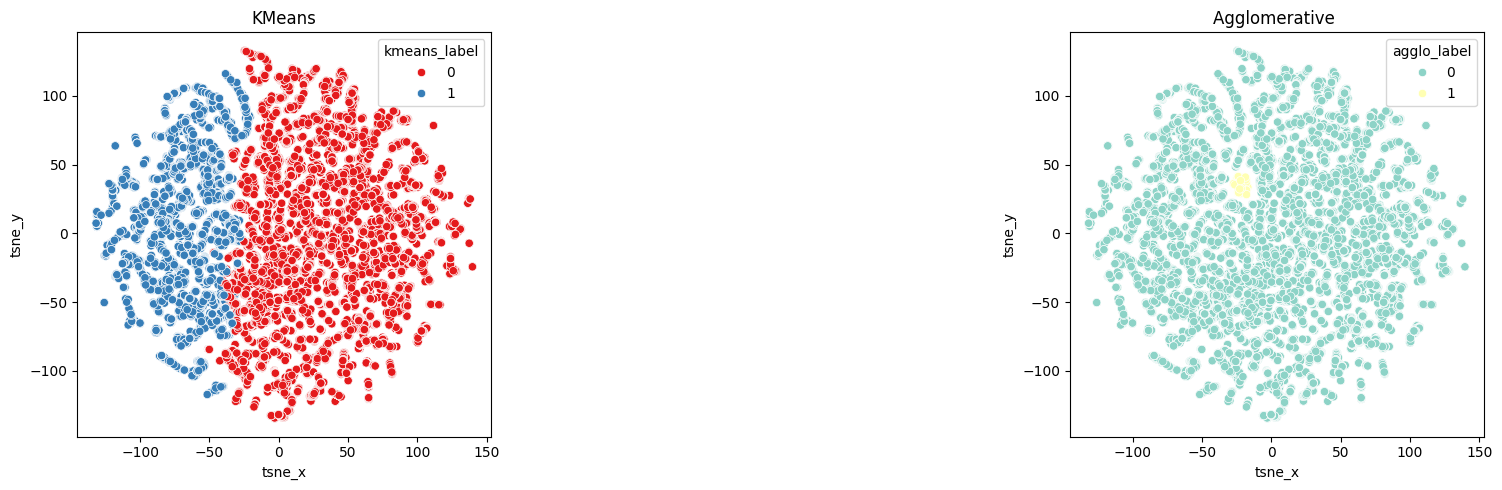

In [40]:
# ---------------------------
# Step 6: Save Results
# ---------------------------
df_result = pd.DataFrame(scaled_features)
df_result["kmeans_label"] = kmeans_labels
df_result["agglo_label"] = agg_labels_corr
df_result.to_csv("sam_features_umap_clustering2.csv", index=False)


# ---------------------------
# Step 7: t-SNE Visualization
# ---------------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_2d = tsne.fit_transform(scaled_features)
df_result["tsne_x"] = tsne_2d[:, 0]
df_result["tsne_y"] = tsne_2d[:, 1]

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="kmeans_label", palette="Set1")
plt.title("KMeans")


plt.subplot(1, 4, 3)
sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="agglo_label", palette="Set3")
plt.title("Agglomerative ")

# plt.subplot(1, 4, 4)
# sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="spectral_label", palette="coolwarm")
# plt.title("Spectral Clustering")

plt.tight_layout()
plt.show()


# experiment